## ガウス過程回帰による推定＆CEMによるベイズ最適化

ガウス過程回帰で推定したモデルをつかって，UCBを最大化するような点をcross entropy法で探索するプログラムです。

まずはテスト用の関数を定義します。

In [1]:
import numpy as np
import scipy as sci
from scipy.stats import norm

def f(x):
    """The function to predict."""
    return x*np.sin(x)

つぎに，カーネル関数およびガウス過程回帰のモデルを用意します。

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# カーネル関数を用意
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
dy = 0.1

# ガウス過程回帰のモデルを用意
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)


ガウス過程回帰を使った推定を関数として定義しなおして，cross entropy法の関数に渡せるようにします。

In [3]:
def gp_pred(x, gp=gp):
    mean, std = gp.predict(x, return_std=True)
    return mean, std

def UCB(x, y_data, f=gp_pred):
    return mean + 2.0*std

def EI(x, y_data, f=gp_pred):
    mean, std = f(x)
    y_max = np.max(y_data)
    ei = (mean - y_max) * norm.cdf((mean - y_max)/std, loc=0, scale=1) + std * norm.pdf((mean - y_max)/std, loc=0, scale=1)

    return ei

cross entropy法の関数を定義します。

In [4]:
import numpy as np

def Cem(objfunc, y_data, x_min=0, x_max=2, dim=1, iterMax=10, sampleNum=700, eliteNum=200):

    mean = None
    std = None
    sampleSet = None
    valueSet = None

    for i in range(iterMax):

        if i == 0:
            sampleSet_i = np.random.uniform(x_min, x_max, (sampleNum, dim))
            sampleSet_i = np.clip(sampleSet_i, x_min, x_max)
        else:
            sampleSet_i = np.random.normal(loc=mean, scale=std, size=sampleNum)
            sampleSet_i = np.clip(sampleSet_i, x_min, x_max)

        sampleSet = np.reshape(sampleSet_i, (sampleNum, -1))
        valueSet = objfunc(sampleSet, y_data)

        value_sort = np.sort(valueSet, axis=None)
        # print('value_sort', value_sort)
        data_num = sampleSet.shape[0]
        v_cut = value_sort[data_num - eliteNum -1]

        # print('sampleSet', sampleSet.shape)
        # print('valueSet', valueSet.shape)
        # print('v_cut', v_cut)
        idx = (valueSet.flatten() > v_cut)
        valueSetCut = valueSet[idx]
        sampleSetCut = sampleSet[idx, :]

        # print('sampleSetCut.shape', sampleSetCut.shape)
        mean = np.mean(sampleSetCut)
        std = np.std(sampleSetCut)

        sampleSetList = list(sampleSetCut)
        valueSetList = list(valueSetCut)


    return np.clip(mean, x_min, x_max)

ノイズがのった観測データを用意します。

In [5]:
# X = np.linspace(0.1, 9.9, 20)
# X = np.random.uniform(0, 10, 7)
X = np.array([0.2, 1.5, 2.1, 3.5, 8.1, 9.5])
X = np.atleast_2d(X).T

y = f(X).ravel()
noise = np.random.normal(0, dy)
y += noise

与えられたデータを使ってガウス過程回帰を行います。

In [6]:
gp.fit(X, y)

GaussianProcessRegressor(alpha=0.010000000000000002,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10)

学習されたガウス過程回帰のモデルに基づいて，UCBを最大化する$x$をcross entropy法で見つけ出します。

In [7]:
 mean = Cem(UCB, y_data=y, dim=1, x_min=0, x_max=10)
#mean = Cem(EI, y_data=y, dim=1, x_min=0, x_max=10)
print('mean', mean)

mean 7.387258798230598


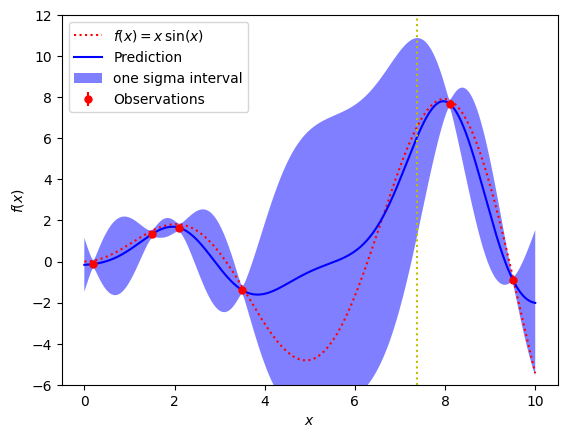

In [8]:
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
y_pred, sigma = gp.predict(x, return_std=True)

from matplotlib import pyplot as plt

y_max = 12
y_min = -6

plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 2.0 * sigma,
                        (y_pred + 2.0 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='one sigma interval')

# plt.fill(np.concatenate([x, x[::-1]]),
        #  np.concatenate([y_pred - 1.9600 * sigma,
                        # (y_pred + 1.9600 * sigma)[::-1]]),
        #  alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.vlines(mean, y_min, y_max, color='y', linestyles='dotted')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(y_min, y_max)
# plt.ylim(-2.5, 2.5)
plt.legend(loc='upper left')


実際にこの$x$の値を試してみたと仮定して，サンプルを追加してみます。

---



In [9]:
X_append = np.append(X, mean)
X_append = np.atleast_2d(X_append).T

追加したデータに合わせて，ガウス過程回帰のモデルを更新し，cross entropy法を再度実行します。

mean 5.708340701030186


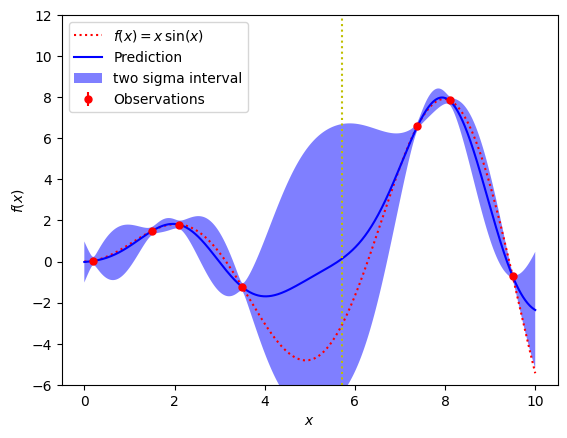

In [12]:
y_append = f(X_append).ravel()
noise_append = np.random.normal(0, dy)
y_append += noise_append

gp.fit(X_append, y_append)

# mean = Cem(UCB, y_append, dim=1, x_min=0, x_max=10)
mean = Cem(EI, y_append, dim=1, x_min=0, x_max=10)
print('mean', mean)

y_pred, sigma = gp.predict(x, return_std=True)

from matplotlib import pyplot as plt

y_max = 12
y_min = -6

plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X_append.ravel(), y_append, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 2.0 * sigma,
                        (y_pred + 2.0 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='two sigma interval')

# plt.fill(np.concatenate([x, x[::-1]]),
        #  np.concatenate([y_pred - 1.9600 * sigma,
                        # (y_pred + 1.9600 * sigma)[::-1]]),
        #  alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.vlines(mean, y_min, y_max, color='y', linestyles='dotted')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(y_min, y_max)
# plt.ylim(-2.5, 2.5)
plt.legend(loc='upper left')

上の結果で，UCBが最大化されるときの入力x|UCB is maxのデータが新たに加えられる．
UCB最大時のデータが加わると，ガウス過程回帰とＵＣＢ最大の予測精度が向上する．

mean 7.913283193902894


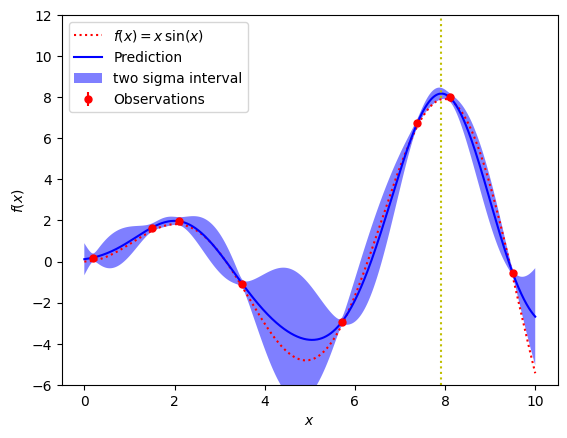

In [11]:
X_append2 = np.append(X_append, mean)
X_append2 = np.atleast_2d(X_append2).T

y_append2 = f(X_append2).ravel()
noise_append = np.random.normal(0, dy)
y_append2 += noise_append

gp.fit(X_append2, y_append2)

# mean = Cem(UCB, y_append2, dim=1, x_min=0, x_max=10)
mean = Cem(EI, y_append2, dim=1, x_min=0, x_max=10)
print('mean', mean)

y_pred, sigma = gp.predict(x, return_std=True)

from matplotlib import pyplot as plt

y_max = 12
y_min = -6

plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.errorbar(X_append2.ravel(), y_append2, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 2.0 * sigma,
                        (y_pred + 2.0 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='two sigma interval')

# plt.fill(np.concatenate([x, x[::-1]]),
        #  np.concatenate([y_pred - 1.9600 * sigma,
                        # (y_pred + 1.9600 * sigma)[::-1]]),
        #  alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.vlines(mean, y_min, y_max, color='y', linestyles='dotted')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(y_min, y_max)
# plt.ylim(-2.5, 2.5)
plt.legend(loc='upper left')